This notebook prepares the ebutterfly data, co-located with ebird, SatButterfly-v2. It starts with clustering the observations around ebird hotspots (with KNN), creates the targets by aggregating the checklists, saves final csv for the hotspots

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from haversine import haversine, Unit
from sklearn.neighbors import BallTree
import os
import json

In [3]:
root_dir = "/data/SatButterfly"
dataset_tag = "SatButterfly_v2"

In [ ]:
# load butterfly observations in the USA
butterfly_data_US = pd.read_csv(os.path.join(root_dir, "occ_usa.csv"))
butterfly_data_US = butterfly_data_US.drop_duplicates()
print(butterfly_data_US.head())

In [ ]:
# load SatBird-USA-summer data
satbird_USA_summer = pd.read_csv(os.path.join(root_dir, "satbird_usa_summer_hotspots_final.csv"))
print(satbird_USA_summer.head())

# 1. Get intersections between ebutterfly and ebird data

In [ ]:
class KNN:
    """
    KNN based on BallTree, used for clustering the data points
    """
    def __init__(self, k=5):
        self.k = k
        self.RADIUS_EARTH = 6356.7523  # in km, polar radius of Earth

    def fit(self, X):
        self.X_train = X
        self.tree = BallTree(np.deg2rad(X), metric='haversine')

    def haversine_distance(self, x1, x2):
        return haversine((x1[0], x1[1]), (x2[0], x2[1]), unit=Unit.KILOMETERS)

    def predict_slow(self, X):
        dist, index = [], []
        for x in tqdm(X):
            d, i = self._predict_single(x)
            dist.append(d)
            index.append(i)
        return np.array(dist), np.array(index)
    
    def predict(self, X):
        dist, index = self.tree.query(np.deg2rad(X), k=self.k)
        dist = dist * self.RADIUS_EARTH
        return dist, index

    def _predict_single(self, x):
        # Compute distances between x and all examples in the training set
        distances = [self.haversine_distance(x, x_train) for x_train in self.X_train]
        # Get indices of k nearest neighbors
        return min(distances), np.argmin(distances)


def get_colocated_butterfly_with_SatBird(butterfly_data_US, satbird_USA_summer):
    """ use KNN to locate butterfly observations with SatBird hotspots
    Parameters:
        butterfly_data_US (Pandas DataFrame): all butterfly observations in the USA
        satbird_USA_summer (Pandas DataFrame) : Satbird USA summer hotspots
    Returns:
          filtered_butterfly_data (Pandas DataFrame): dataframe of butterfly observations assigned to SatBird hotspots
    """
    coordinates = butterfly_data_US[['decimalLatitude', 'decimalLongitude']].values
    center_coordinates = satbird_USA_summer[['lat', 'lon']].values
    
    # Create a KNN classifier, with k=1
    knn = KNN(k=1)
    
    # fit ebird hotspots
    knn.fit(center_coordinates)
    
    # cluster ebutterfly observations into ebird hotspts
    distances, indices = knn.predict(coordinates)
    
    print(len(distances), distances.min(), distances.max())
    print(len(indices))
    
    butterfly_data_US['ebird_hotspot'] = satbird_USA_summer.iloc[indices.flatten()]['hotspot_id'].values
    butterfly_data_US['ebird_lon'] = satbird_USA_summer.iloc[indices.flatten()]['lon'].values
    butterfly_data_US['ebird_lat'] = satbird_USA_summer.iloc[indices.flatten()]['lat'].values
    butterfly_data_US['distance'] = distances
    butterfly_data_US['ebird_split'] = satbird_USA_summer.iloc[indices.flatten()]['split'].values
    
    # kilometer threshold for distance
    km_threshold = 1
    
    # final butterfly data after filtering out outliers
    filtered_butterfly_data = butterfly_data_US[butterfly_data_US.distance < km_threshold].reset_index()
    
    print(filtered_butterfly_data['ebird_hotspot'].value_counts())
    print(filtered_butterfly_data)
    print(filtered_butterfly_data[['decimalLatitude', 'decimalLongitude', 'ebird_hotspot', 'ebird_lat', 'ebird_lon', 'distance', 'ebird_split']])
    
    return filtered_butterfly_data

filtered_butterfly_data = get_colocated_butterfly_with_SatBird(butterfly_data_US, satbird_USA_summer)
filtered_butterfly_data.to_csv(os.path.join(root_dir, dataset_tag, "butterfly_data_with_distance_wSatBird.csv"))

# 2. Group butterfly checklists based on final hotspots

In [ ]:
def group_clusters(butterfly_df):
    """ groups observations according to the center of clusters (hotspot_ID)
    Parameters:
        butterfly_df: Pandas DataFrame of butterfly observations
    Returns: 
        grouped_butterfly_data: Pandas DataFrame of butterfly observations after grouping
    """
    grouped_butterfly_data = butterfly_df.groupby(['ebird_hotspot'])
    group_sizes = grouped_butterfly_data.size()
    print(group_sizes)
    
    return grouped_butterfly_data


clustered_butterfly_data = pd.read_csv(os.path.join(root_dir, dataset_tag, "butterfly_data_with_distance_wSatBird.csv"))
grouped_butterfly_data = group_clusters(clustered_butterfly_data)

In [ ]:
def save_species_list(df):
    """ save species list of all unique species, with their frequency in raw observations
    Parameters:
        df: Pandas DataFrame of butterfly observations
    Returns:
        species_list: list of species names
    """
    species_df = df['species'].value_counts()
    
    species_df = species_df.reset_index()
    species_df.columns = ['species', 'frequency']
    
    species_df.to_csv(os.path.join(root_dir, dataset_tag, 'species/full_species_list.csv'), index=False)
    
    species_list = species_df["species"].values.tolist()
    
    print(len(species_list), species_list)
    
    total_number_of_checklists = len(filtered_butterfly_data["eventID"].unique().tolist())
    print(total_number_of_checklists)

    return species_list

species_list = save_species_list(filtered_butterfly_data)

# 3. Save target files 

In [ ]:
def compute_target_files(grouped_butterfly_data, output_folder, species_list):
    """Creates targets by aggregating checklists, and saves json file per hotspot in output_folder
    Parameters:
        grouped_butterfly_data: Pandas DataFrame all butterfly observations, grouped per hotspot
        output_folder: folder name to save .json target files
        species_list: list of species to consider
    Returns:
    """
    non_zero_target = []
    for group_name, group_data in tqdm(grouped_butterfly_data):
        target = {}
        checklist_ = np.zeros(len(species_list))
        # dropping species that appear more than once in the same checklist
        new_df = group_data[['eventID', 'species']]
        new_df = new_df.drop_duplicates(['eventID', 'species'])

        for sp in new_df['species']:
            if sp in species_list:
                checklist_[species_list.index(sp)] += 1

        target['num_complete_checklists'] = len(group_data['eventID'].unique())
        checklist_ = checklist_ / target['num_complete_checklists']
        # if np.max(checklist_) > 1 :
        #     problems.append(group_name)
        # # NEW: to match SatBird scale
        # if target['num_complete_checklists'] < 5:
        #     continue
        non_zero_target.append(np.count_nonzero(checklist_))
        target['probs'] = checklist_.tolist()
        
        target['hotspot_id'] = group_name[0]

        with open(os.path.join(output_folder, group_name[0] + '.json'), 'w') as fp:
            json.dump(target, fp)
    
path = os.path.join(root_dir, dataset_tag, 'butterfly_targets_v1.2')
if not os.path.exists(path):
    os.mkdir(path)

# species_list to use is the intersection of species among this dataset, SatButterfly-v2, and the non-located butterflies dataset, SatButterfly-v1, (total species: 172)
final_species_list_intersect = open(os.path.join(root_dir, 'species/intersection_species_list_occurrences_ge100.txt')).read().split("\n") 
compute_target_files(grouped_butterfly_data, path, final_species_list_intersect)

# 4. Create final csv

In [ ]:
def save_final_csv(grouped_butterfly_data, output_filename='butterfly_hotspots.csv'):
    """ saves csv file with final hotspots with columns: hotspot_name, lon, lat, number_of_observations, number_of_unique_checklists, number_of_unique_species, env variables
    Parameters:
        grouped_butterfly_data: Pandas DataFrame all butterfly observations, grouped per hotspot
        output_filename: filename to save
    Returns:
    """
    hotspot_ids = []
    lats, lons = [], []
    number_of_butterfly_obs = []
    number_of_unique_checklists = []
    number_of_different_species = []
    
    bio_env_column_names = ['bio_1', 'bio_2', 'bio_3', 'bio_4', 'bio_5',
           'bio_6', 'bio_7', 'bio_8', 'bio_9', 'bio_10', 'bio_11', 'bio_12',
           'bio_13', 'bio_14', 'bio_15', 'bio_16', 'bio_17', 'bio_18', 'bio_19']
    ped_env_column_names = ['bdticm', 'bldfie', 'cecsol', 'clyppt', 'orcdrc', 'phihox', 'sltppt', 'sndppt']
    location_info = ['county_code', 'state', 'state_code']
    
    for group_name, group_data in tqdm(grouped_butterfly_data):
        # # NEW: to match SatBird scale
        # if len(group_data['eventID'].unique()) < 5:
        #     continue
        hotspot_ids.append(group_name[0])
        lats.append(group_data['ebird_lat'].iloc[0])
        lons.append(group_data['ebird_lon'].iloc[0])
        number_of_butterfly_obs.append(len(group_data['occurrenceID']))
        number_of_unique_checklists.append(len(group_data['eventID'].unique()))
        number_of_different_species.append(len(group_data['species'].unique()))
    
    final_data_frame = pd.DataFrame({'hotspot_id': hotspot_ids,
                                     'lat': lats,
                                     'lon': lons,
                                     'ebutterfly_occurrences': number_of_butterfly_obs,
                                     'num_checklists': number_of_unique_checklists,
                                     'num_species': number_of_different_species})
        
    
    indices = satbird_USA_summer[satbird_USA_summer['hotspot_id'].isin(final_data_frame['hotspot_id'])].index
    
    bio_env_indices = [satbird_USA_summer.columns.get_loc(c) for c in bio_env_column_names]
    ped_env_indices = [satbird_USA_summer.columns.get_loc(c) for c in ped_env_column_names]
    location_info_indices = [satbird_USA_summer.columns.get_loc(c) for c in location_info]
    
    final_data_frame[bio_env_column_names] = satbird_USA_summer.iloc[indices, bio_env_indices].values
    final_data_frame[ped_env_column_names] = satbird_USA_summer.iloc[indices, ped_env_indices].values
    final_data_frame[location_info] = satbird_USA_summer.iloc[indices, location_info_indices].values
    final_data_frame.to_csv(os.path.join(root_dir, dataset_tag, output_filename) , index=False)


save_final_csv(grouped_butterfly_data, output_filename='butterfly_hotspots_ebird_all.csv')

# 5. Create train/val/test splits

In [ ]:
def resplit_ebutterfly_with_ebird(ebutterfly_df, ebird_df):
    """ split butterfly hotspots aligned with train/val/test splits, and saves files
    Parameters:
        ebutterfly_df (Pandas DataFrame): dataframe with all butterfly hotspots 
        ebird_df (Pandas DataFrame): dataframe with SatBird-USA-summer hotspots
    Returns:
    """
    out = ebutterfly_df.merge(ebird_df[['hotspot_id', 'split']], on='hotspot_id', how='right')
    ebutterfly_df = out[out['hotspot_id'].isin(ebutterfly_df['hotspot_id'])]
    print(ebutterfly_df['split'].value_counts())
    
    ebutterfly_df.to_csv(os.path.join(root_dir, dataset_tag, 'butterfly_hotspots_ebird_splits.csv') , index=False)

    grouped_butterfly_data = ebutterfly_df.groupby(['split'], as_index=False)

    for group_name, group_data in tqdm(grouped_butterfly_data):
        group_data.to_csv(os.path.join(root_dir, dataset_tag, "butterfly_hotspots_ebird_" + str(group_name[0]) + ".csv"))
    
final_ebutterfly_df = pd.read_csv(os.path.join(root_dir, dataset_tag, 'butterfly_hotspots_ebird_all.csv'))
print(final_ebutterfly_df)
final_ebird_df = pd.read_csv(os.path.join(root_dir, 'satbird_usa_summer_hotspots_final.csv'))
resplit_ebutterfly_with_ebird(final_ebutterfly_df, final_ebird_df)

# 5. Visualize map after splitting

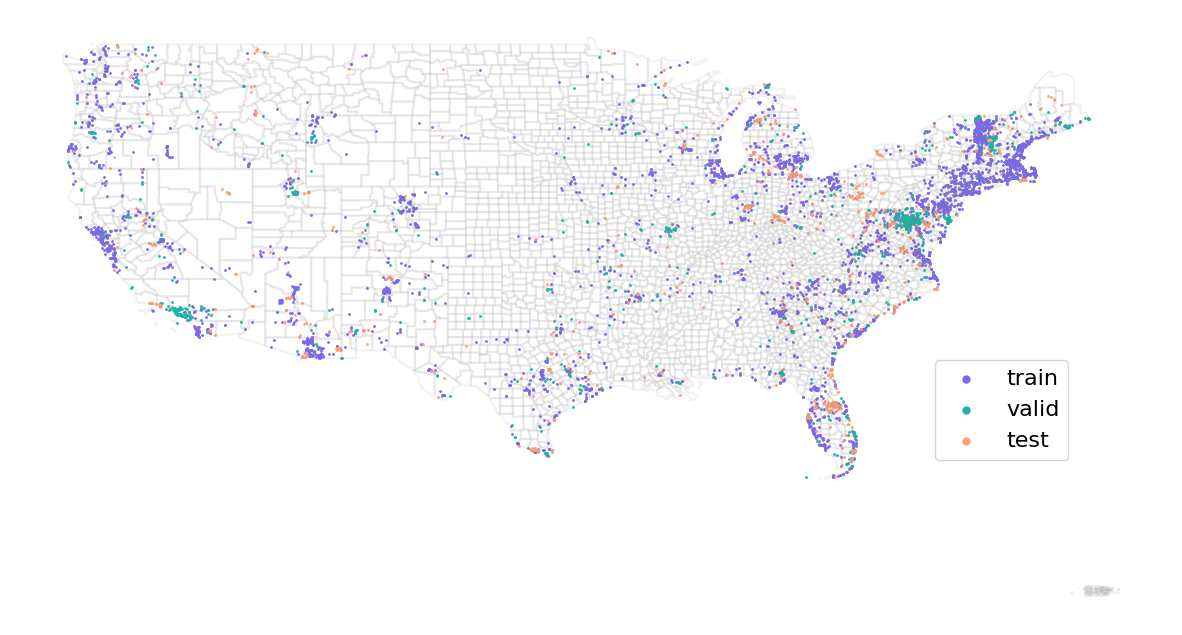

In [5]:
import os
import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parent))
sys.path.append(str(Path().resolve().parent.parent))

import numpy as np
import pandas as pd
import json

import geopandas as gpd
import matplotlib.pyplot as plt

from shapely.geometry import Point

def plot_final_splits(train_df, valid_df, test_df, save_path):
    geoDatav = gpd.read_file(
        'https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson'
    )
    
    # Add geometry columns
    train_gdf = gpd.GeoDataFrame(train_df, geometry=[Point(xy) for xy in zip(train_df['lon'], train_df['lat'])])
    valid_gdf = gpd.GeoDataFrame(valid_df, geometry=[Point(xy) for xy in zip(valid_df['lon'], valid_df['lat'])])
    test_gdf  = gpd.GeoDataFrame(test_df,  geometry=[Point(xy) for xy in zip(test_df['lon'],  test_df['lat'])])

    fig, ax = plt.subplots(figsize=(15, 10))
    geoDatav[~geoDatav["STATE"].isin(["02", "15"])].boundary.plot(ax=ax, alpha=0.1, edgecolor="gray")
    train_gdf.plot(ax=ax, marker='o', color='mediumslateblue', markersize=1, label="train")
    valid_gdf.plot(ax=ax, marker='o', color='lightseagreen', markersize=1, label="valid")
    test_gdf.plot(ax=ax, marker='o', color='lightsalmon', markersize=1, label="test")

    plt.legend(fontsize=16, markerscale=5, loc='lower right', bbox_to_anchor=(0.92, 0.25))
    # plt.title("Butterfly Hotspots")
    ax.axis('off')
    plt.show()
    # Save figure
    fig.savefig(os.path.join(save_path, "satbutterfly_v2_data_dist.jpeg"), bbox_inches='tight')

path = os.path.join(root_dir, dataset_tag)
plot_final_splits(train_df=pd.read_csv(path + "/train_split.csv"), valid_df=pd.read_csv(path + "/valid_split.csv"), test_df=pd.read_csv(path + "/test_split.csv"), save_path=path)

Final files saved:
[('valid', 1076), ('test', 958), ('train', 4650)]